# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/sophie/Desktop/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
# Read in the lyrics data
lyrics_data = defaultdict(dict)

for item in os.listdir(data_location + lyrics_folder):
    if os.path.isdir(data_location + lyrics_folder + item):
        for lyrics_page in os.listdir(data_location + lyrics_folder + item):
            artist = lyrics_page.split("_")[0]
            # Get the song name from the first line of the txt file
            with open(data_location + lyrics_folder + item + "/" + lyrics_page) as file:
                song = file.readline().strip() # Read the first line and remove any extra spaces/newlines
                lyrics = file.read() # Read the rest of the file for the lyrics 
            lyrics_data[item][song] = lyrics

# Create a DataFrame with the lyrics data
lyrics_data = pd.DataFrame.from_dict(lyrics_data, orient='index').T 
lyrics_data.index.name = 'song'
lyrics_data.columns.name = 'artist'
# Transpose the DataFrame
lyrics_data = lyrics_data.stack().reset_index() 
lyrics_data.columns = ['song', 'artist', 'lyrics']
lyrics_data

,song,artist,lyrics
0,"""Include Me Out""",robyn,\n\n\nIt is really very simple\nJust a single ...
1,"""Electric""",robyn,\n\n\nElectric...\n\nIt's electric\nIt's a nat...
2,"""Beach 2K20""",robyn,\n\n\n(So you wanna go out?\nHow you gonna get...
3,"""Love Kills""",robyn,\n\n\nIf you're looking for love\nGet a heart ...
4,"""Time Machine""",robyn,"\n\n\nHey, what did I do?\nCan't believe the f..."
...,...,...,...
401,"""Take It From The Boys""",cher,\n\n\nSo scared I never been\nToo hard to keep...
402,"""Dream Baby""",cher,\n\n\nI found the boy for me\nHe's my dream ba...
403,"""Please Don't Tell Me""",cher,\n\n\nYa shook the override \nWhy'd I get this...
404,"""I Hope You Find It""",cher,"\n\n\nThese clouds aren't going nowhere, darli..."


In [16]:
# Read in the twitter data
twitter = os.listdir(data_location + twitter_folder)
description_field = [f for f in twitter if "followers_data" in f] #description field is in this .txt file

twitter_data = defaultdict(list)

for f in description_field:
    # Get the artist name from the filename
    # The artist name is the first part of the filename, before the underscore
    artist = f.split("_")[0]
    artist_map = {"robynkonichiwa": "robyn", "cher_official": "cher"} # map the artist names to the correct format
    artist = artist_map.get(artist, artist)

    with open(data_location + twitter_folder + f, 'r', encoding='utf-8') as infile:
        next(infile) # open each file skip the header
        for idx, line in enumerate(infile.readlines()):

            line = line.strip().split("\t") # reads lines splitting using tab 
            if len(line) == 7: #appends the 7th column (description field)
                twitter_data[artist].append(line[6])

# Create a DataFrame with the twitter data
twitter_df = pd.DataFrame.from_dict(twitter_data, orient='index').T
twitter_df.index.name = "tweet"
twitter_df.columns.name = "artist"
# Transpose the DataFrame
twitter_df = twitter_df.stack().reset_index()
twitter_df.columns = ['tweet', 'artist', 'text']

twitter_df.head()

,tweet,artist,text
0,0,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
1,0,robyn,"""I love chill"" •Facebook / Instagram / SoundCl..."
2,1,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,1,robyn,"books, movies, music, nature & TV shows. OG Sw..."
4,2,cher,csu


In [17]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.


# Read positive words
with open(positive_words_file, 'r') as f:
    positive_words = [line.strip() for line in f if line.strip() and not line.startswith(';')]
# Read negative words
with open(negative_words_file, 'r') as f:
    negative_words = [line.strip() for line in f if line.strip() and not line.startswith(';')]

# Read tidytext sentiments
tidy_sentiments = pd.read_csv(tidy_text_file, sep="\t")

# Create a sentiment dictionary
positive_dict = {word: 1 for word in positive_words}
negative_dict = {word: -1 for word in negative_words}

# Read tidy text sentiments
tidy_text_sentiments = pd.read_csv(tidy_text_file, sep="\t")


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [18]:
# your code here
# score sentiment for all songs in lyrics_data for both artists 
sentiment_scores_lyrics = []
for lyrics in lyrics_data['lyrics']:
    sentiment_score = 0
    words = lyrics.split()
    for word in words:
        if word in positive_dict:
            sentiment_score += positive_dict[word]
        elif word in negative_dict:
            sentiment_score += negative_dict[word]
    sentiment_scores_lyrics.append(sentiment_score)

# Add the computed scores to your DataFrame
lyrics_data['sentiment_score'] = sentiment_scores_lyrics

# Display the first few sentiment scores
lyrics_data['sentiment_score'].head()

0    -8
1    -9
2    20
3   -19
4    -3
Name: sentiment_score, dtype: int64

In [19]:
# Calculate the average sentiment score for each artist
average_sentiment_lyrics = lyrics_data.groupby('artist')['sentiment_score'].mean().reset_index()
# Display the average sentiment scores for each artist
average_sentiment_lyrics.columns = ['artist', 'average_sentiment_score']
average_sentiment_lyrics

,artist,average_sentiment_score
0,cher,2.124601
1,robyn,1.817204


In [20]:
# what are the three songs that have the hiighest and lowest sentiments for each artist?
highest_lowest_songs = defaultdict(dict)
for artist in lyrics_data['artist'].unique():
    artist_songs = lyrics_data[lyrics_data['artist'] == artist]
    highest_songs = artist_songs.nlargest(3, 'sentiment_score')[['song', 'sentiment_score']]
    lowest_songs = artist_songs.nsmallest(3, 'sentiment_score')[['song', 'sentiment_score']]
    
    highest_lowest_songs[artist]['highest'] = highest_songs
    highest_lowest_songs[artist]['lowest'] = lowest_songs
# Display the highest and lowest sentiment songs for each artist
for artist, songs in highest_lowest_songs.items():
    print(f"Artist: {artist}")
    print("Highest Sentiment Songs:")
    print(songs['highest'])
    print("Lowest Sentiment Songs:")
    print(songs['lowest'])
    print("\n")

Artist: robyn
Highest Sentiment Songs:
                song  sentiment_score
19    "Love Is Free"               58
66  "Indestructible"               27
40  "Buffalo Stance"               25
Lowest Sentiment Songs:
                                  song  sentiment_score
47  "Don't Fucking Tell Me What To Do"              -78
14                   "Criminal Intent"              -46
3                         "Love Kills"              -19


Artist: cher
Highest Sentiment Songs:
                         song  sentiment_score
196              "Perfection"               41
239  "Love And Understanding"               36
175           "Strong Enough"               29
Lowest Sentiment Songs:
                              song  sentiment_score
264  "I Walk On Guilded Splinters"              -25
251                   "Outrageous"              -20
100                        "Julie"              -18




In [21]:
# print the lyrics for the song with the highest and lowest sentiment for each artist
for artist, songs in highest_lowest_songs.items():
    print(f"Artist: {artist}")
    print("Highest Sentiment Songs:")
    for _, row in songs['highest'].iterrows():
        song = row['song']
        lyrics = lyrics_data[(lyrics_data['artist'] == artist) & (lyrics_data['song'] == song)]['lyrics'].values[0]
        print(f"Song: {song}\nLyrics:\n{lyrics}\n")
    
    print("Lowest Sentiment Songs:")
    for _, row in songs['lowest'].iterrows():
        song = row['song']
        lyrics = lyrics_data[(lyrics_data['artist'] == artist) & (lyrics_data['song'] == song)]['lyrics'].values[0]
        print(f"Song: {song}\nLyrics:\n{lyrics}\n")

Artist: robyn
Highest Sentiment Songs:
Song: "Love Is Free"
Lyrics:



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you,

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Overall, Cher has the highest average sentiment per song with and average score of 2.12. Robyn has a lower average sentiment score of 1.82. 

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Robyn's highest sentiment songs are "Love is Free," "Indestructible," and "Buffalo Stance." Robyn's lowest sentiment songs are "Don't Fucking Tell Me What To Do," "Criminal Intent," and "Love Kills." For the highest sentiment songs, they use words like "love," "dance," "romance" that are cheerful and have a more positive meaning. The lowest sentiment score songs, just even in the title show a more negative connotation. 

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Cher's highest sentiment songs are "Perfection," "Love And Understanding," and "Strong Enough." The lowest sentiment songs are "I Walk On Guilded Splinters," "Outrageous," and "Julie." For the highest sentiment songs, words like "perfection," "love," "believe," and "strong" are used frequently in the songs showing the words are more positive. The lowest sentiment scores have more negative lyrics using words like "splinters," "outrageous," "crazy," and "cry."

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




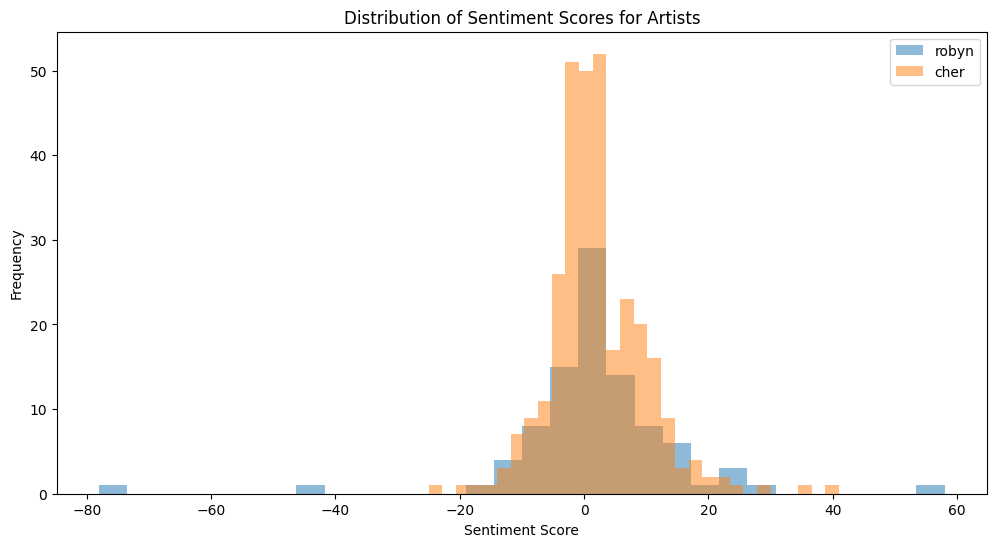

In [23]:
# plot distributions of the sentiment scores for both artists 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for artist in lyrics_data['artist'].unique():
    plt.hist(lyrics_data[lyrics_data['artist'] == artist]['sentiment_score'], 
             bins=30, alpha=0.5, label=artist)
plt.title('Distribution of Sentiment Scores for Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [24]:
# your code here
# define two sets of emojis you designate as positive and negative (10 emojis per set)
# Positive emoji characters
positive_emojis = ['❤️', '😍', '😊', '💕', '😘', '🔥', '✨', '😎', '💖', '🙌']

# Negative emoji characters
negative_emojis = ['😭', '😬', '😔', '😒', '😢', '💀', '😞', '😑', '😠', '😤']

In [25]:
# Step 1: Build a dictionary of artist -> list of tweets
twitter_descriptions = {}

for index, row in twitter_df.iterrows():
    artist = row['artist']
    text = str(row['text'])  # Make sure it's a string
    if artist not in twitter_descriptions:
        twitter_descriptions[artist] = []
    twitter_descriptions[artist].append(text)

# Step 2: Compute emoji sentiment per artist
sentiment_scores_twitter = {}

for artist, descriptions in twitter_descriptions.items():
    total_score = 0
    num_descriptions = len(descriptions)

    for description in descriptions:
        sentiment_score = 0
        for emoji in positive_emojis:
            if emoji in description:
                sentiment_score += 1
        for emoji in negative_emojis:
            if emoji in description:
                sentiment_score -= 1
        total_score += sentiment_score

    average_sentiment = total_score / num_descriptions if num_descriptions > 0 else 0
    sentiment_scores_twitter[artist] = average_sentiment

# Step 3: Display results
for artist, sentiment_score in sentiment_scores_twitter.items():
    print("Artist:", artist)
    print("Average Sentiment:", sentiment_score)


Artist: cher
Average Sentiment: 0.04760955279372742
Artist: robyn
Average Sentiment: 0.029094946667157808


In [27]:
# positive emoji is most popular for each artist 
most_popular_positive_emoji = {}
for artist, descriptions in twitter_descriptions.items():
    emoji_count = Counter()
    for description in descriptions:
        for emoji_char in positive_emojis:
            if emoji_char in description:
                emoji_count[emoji_char] += 1
    if emoji_count:
        most_popular_positive_emoji[artist] = emoji_count.most_common(1)[0][0]
    else:
        most_popular_positive_emoji[artist] = None
# Display the most popular positive emoji for each artist
for artist, emoji_char in most_popular_positive_emoji.items():
    print(f"Artist: {artist}, Most Popular Positive Emoji: {emoji_char}")
# negative emoji is most popular for each artist
most_popular_negative_emoji = {}
for artist, descriptions in twitter_descriptions.items():
    emoji_count = Counter()
    for description in descriptions:
        for emoji_char in negative_emojis:
            if emoji_char in description:
                emoji_count[emoji_char] += 1
    if emoji_count:
        most_popular_negative_emoji[artist] = emoji_count.most_common(1)[0][0]
    else:
        most_popular_negative_emoji[artist] = None
# Display the most popular negative emoji for each artist
for artist, emoji_char in most_popular_negative_emoji.items():
    print(f"Artist: {artist}, Most Popular Negative Emoji: {emoji_char}")
    

Artist: cher, Most Popular Positive Emoji: ❤️
Artist: robyn, Most Popular Positive Emoji: ❤️
Artist: cher, Most Popular Negative Emoji: 💀
Artist: robyn, Most Popular Negative Emoji: 💀


Q: What is the average sentiment of your two artists? 

A: The average sentiment for Cher is 0.0478 and the average sentiment for Robyn is 0.029. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: It appears both artists have the same positive emoji (❤️) and also the same negative emoji (💀)

